# Using Clustering to Reduce Log Error in Zillow Dataset

## Project Plan

### Goals

### Hypothesis

### Components

In [1]:
import acquire
import prep
import split_scale
import explore

## Acquire

### Pull SQL data and filter data frame

Using the `get_sql_zillow` function from the `acquire` module, pull all the columns from the Zillow dataset from SQL following the conditions below:
 - only include properties that have recorded transactions in 2017
 - use a left join to merge all tables of descriptions on their associated id property
 - exclude properties that do not have latitude and longitude values (location is important in our analysis later so we wante to make sure we are including observations with known locations.)

In [2]:
# get_sql_zillow code here
# df = acquire.get_sql_zillow()

In [3]:
import pandas as pd

# read sql data from csv to minimize lag
df = pd.read_csv(r'/Users/mists/codeup-data-science/zillow-cluster/query_result.csv')
# df = pd.read_csv(r'/Users/cris/codeup-data-science/zillow-cluster/query_result.csv')

Using the `wrangle_zillow` function, perform initial cleaning of the original dataframe specifically:
 - Drop redundant ID columns from Left Joins (typeconstructionid, storytypeid, etc.)
 - Remove duplicates from multiple transactions by maintaining latest transaction date and dropping previous records
 - Include property land use type "Single Family Residential" only, and drop the rest of the observations
 - Drop properties that have unit counts of 2 (27 rows) and 3 (1 row) to remove ambiguity in the definition of "single-unit" or "single-family" houses, especially since the total number of these observations are relatively minimal.
 - Keep transactions that are recorded in 2017 (there was 1 row that has 2018 as transaction year)

In [4]:
# wrangle_zillow code here
df = acquire.wrangle_zillow(df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52292 entries, 77578 to 0
Data columns (total 61 columns):
parcelid                        52292 non-null int64
basementsqft                    47 non-null float64
bathroomcnt                     52292 non-null float64
bedroomcnt                      52292 non-null int64
buildingqualitytypeid           33632 non-null float64
calculatedbathnbr               52158 non-null float64
decktypeid                      388 non-null float64
finishedfloor1squarefeet        4368 non-null float64
calculatedfinishedsquarefeet    52211 non-null float64
finishedsquarefeet12            52047 non-null float64
finishedsquarefeet13            0 non-null float64
finishedsquarefeet15            0 non-null float64
finishedsquarefeet50            4368 non-null float64
finishedsquarefeet6             164 non-null float64
fips                            52292 non-null int64
fireplacecnt                    7230 non-null float64
fullbathcnt                     521

## Prepare

### Handling missing values

**Drop Unsalvagable Columns and Rows**

`handle_missing_values` function from the `prep` module drops columns that are 90% empty, reducing our columns from 60 to 27. Then, remove observations that are 40% empty. The latter removed no observations.  
  
In this stage, our working data has 52292 rows with 27 columns.

In [6]:
df = prep.handle_missing_values(df,.90,.40)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52292 entries, 77578 to 0
Data columns (total 28 columns):
parcelid                        52292 non-null int64
bathroomcnt                     52292 non-null float64
bedroomcnt                      52292 non-null int64
calculatedbathnbr               52158 non-null float64
calculatedfinishedsquarefeet    52211 non-null float64
finishedsquarefeet12            52047 non-null float64
fips                            52292 non-null int64
fullbathcnt                     52158 non-null float64
latitude                        52292 non-null int64
longitude                       52292 non-null int64
lotsizesquarefeet               51930 non-null float64
propertycountylandusecode       52292 non-null object
rawcensustractandblock          52292 non-null float64
regionidcity                    51256 non-null float64
regionidcounty                  52292 non-null int64
regionidzip                     52266 non-null float64
roomcnt                 

**Drop Non-value-adding Columns**

*dropping parcelid*

`bathroomcnt` reflects the same information as the `calculatedbathnbr`, which is the number of bathrooms in a property including half bathrooms (.5's). The	`fullbathcnt` column only includes full bathrooms and discounts half baths. So, we are discarding redundant `calculatedbathnbr` and `fullbathcnt` and keep `bathroomcnt` to provide information on the properties' bathrooms.

`calculatedfinishedsquarefeet` and `finishedsquarefeet12` hold practically the same information. `calculatedfinishedsquarefeet` has less nulls (81 rows) than `finishedsquarefeet12` (245 rows), so we are dropping the `finishedsquarefeet12`.

`propertycountylandusecode` are codes used in the industry to specify the land use. For example, a Single Family Residential property land use type may be Single Family Class II (0102), Vacant Residential (0000), Vacant Lake View (0035), etc. We don't need these further information. All we need to know is that the properties that we are looking at are under the umbrella of "Single Family Residential."

`rawcensustractandblock` and `censustractandblock` contain census information that we are not concerned about in this project.

`roomcnt` has 37,588 properties with 0 rooms, so we are dropping this column.

`fips` and `regionidcounty` have cotain the same information. We will keep the `fips` column.

`regionidzip` and `regionidcity` are location-based columns which do not give much added information on the properties' location given that we have `latitude` and `longitude`. These columns are dropped.

All wrangled observation have "2016" as values in the `assessmentyear` which is not adding value to the analysis.

`propertylandusedesc` is dropped because it only displays "Single Family Residential" which was helpful in the filtering phase but not useful in the analysis.

In [8]:
df = prep.clean_columns(df)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52292 entries, 77578 to 0
Data columns (total 15 columns):
bathroomcnt                     52292 non-null float64
bedroomcnt                      52292 non-null int64
calculatedfinishedsquarefeet    52211 non-null float64
fips                            52292 non-null int64
latitude                        52292 non-null int64
longitude                       52292 non-null int64
lotsizesquarefeet               51930 non-null float64
yearbuilt                       52178 non-null float64
structuretaxvaluedollarcnt      52213 non-null float64
taxvaluedollarcnt               52291 non-null float64
landtaxvaluedollarcnt           52291 non-null float64
taxamount                       52288 non-null float64
id.1                            52292 non-null int64
logerror                        52292 non-null float64
transactiondate                 52292 non-null object
dtypes: float64(9), int64(5), object(1)
memory usage: 6.4+ MB


**Handle Nulls for Relevant Columns**

In [10]:
# show null values
df.isnull().sum()

bathroomcnt                       0
bedroomcnt                        0
calculatedfinishedsquarefeet     81
fips                              0
latitude                          0
longitude                         0
lotsizesquarefeet               362
yearbuilt                       114
structuretaxvaluedollarcnt       79
taxvaluedollarcnt                 1
landtaxvaluedollarcnt             1
taxamount                         4
id.1                              0
logerror                          0
transactiondate                   0
dtype: int64

_Calculated Finished Square Feet, Structure Tax Value Dollar Count_ -  Observations that have missing values in either `calculatedfinishedsquarefeet` (71 rows) or  `structuretaxvaluedollarcnt` (69 rows), both (10 rows) are dropped, removing a total of 150 observations.

_Tax Value Dollar Count, Land Tax Value Dollar Count_ - There are a handful of observations with missing values in the columns `taxvaluedollarcnt` (1 row), `landtaxvaluedollarcnt` (1 row), `taxamount` (4 rows).

_Year Built_ - After all the above removals, `yearbuilt` have a total of 38 missing values which are dropped because of the manageable size.

In [11]:
df = prep.drop_minimal_nulls(df)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52101 entries, 77578 to 0
Data columns (total 15 columns):
bathroomcnt                     52101 non-null float64
bedroomcnt                      52101 non-null int64
calculatedfinishedsquarefeet    52101 non-null float64
fips                            52101 non-null int64
latitude                        52101 non-null int64
longitude                       52101 non-null int64
lotsizesquarefeet               51761 non-null float64
yearbuilt                       52101 non-null float64
structuretaxvaluedollarcnt      52101 non-null float64
taxvaluedollarcnt               52101 non-null float64
landtaxvaluedollarcnt           52101 non-null float64
taxamount                       52101 non-null float64
id.1                            52101 non-null int64
logerror                        52101 non-null float64
transactiondate                 52101 non-null object
dtypes: float64(9), int64(5), object(1)
memory usage: 6.4+ MB


**Renamed and reordered columns**

In [13]:
df = prep.pretty_cols(df)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52101 entries, 77578 to 0
Data columns (total 14 columns):
countyid           52101 non-null int64
latitude           52101 non-null int64
longitude          52101 non-null int64
yearbuilt          52101 non-null float64
bathroomcnt        52101 non-null float64
bedroomcnt         52101 non-null int64
house_area         52101 non-null float64
whole_area         51761 non-null float64
house_value        52101 non-null float64
land_value         52101 non-null float64
whole_value        52101 non-null float64
taxamount          52101 non-null float64
logerror           52101 non-null float64
transactiondate    52101 non-null object
dtypes: float64(9), int64(4), object(1)
memory usage: 6.0+ MB


### Derived Features

**Calculate a tax rate from tax amount and tax home value**

In [15]:
df = prep.cal_taxrate(df)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52101 entries, 77578 to 0
Data columns (total 14 columns):
countyid           52101 non-null int64
latitude           52101 non-null int64
longitude          52101 non-null int64
yearbuilt          52101 non-null float64
bathroomcnt        52101 non-null float64
bedroomcnt         52101 non-null int64
house_area         52101 non-null float64
whole_area         51761 non-null float64
house_value        52101 non-null float64
land_value         52101 non-null float64
whole_value        52101 non-null float64
logerror           52101 non-null float64
transactiondate    52101 non-null object
taxrate            52101 non-null float64
dtypes: float64(9), int64(4), object(1)
memory usage: 6.0+ MB


**As all transactions are in 2017, take only the month from the transaction date**

In [17]:
df = prep.define_month(df)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52101 entries, 77578 to 0
Data columns (total 14 columns):
countyid       52101 non-null int64
latitude       52101 non-null int64
longitude      52101 non-null int64
yearbuilt      52101 non-null float64
bathroomcnt    52101 non-null float64
bedroomcnt     52101 non-null int64
house_area     52101 non-null float64
whole_area     51761 non-null float64
house_value    52101 non-null float64
land_value     52101 non-null float64
whole_value    52101 non-null float64
logerror       52101 non-null float64
taxrate        52101 non-null float64
month          52101 non-null int64
dtypes: float64(9), int64(5)
memory usage: 6.0 MB


## Split

**Split dataframe into train and test**

In [19]:
# a random state of 123 is set in .py file
train, test = split_scale.split_my_data(df, .80)

In [20]:
print(train.info())
print()
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41680 entries, 28235 to 54472
Data columns (total 14 columns):
countyid       41680 non-null int64
latitude       41680 non-null int64
longitude      41680 non-null int64
yearbuilt      41680 non-null float64
bathroomcnt    41680 non-null float64
bedroomcnt     41680 non-null int64
house_area     41680 non-null float64
whole_area     41405 non-null float64
house_value    41680 non-null float64
land_value     41680 non-null float64
whole_value    41680 non-null float64
logerror       41680 non-null float64
taxrate        41680 non-null float64
month          41680 non-null int64
dtypes: float64(9), int64(5)
memory usage: 4.8 MB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10421 entries, 37917 to 44340
Data columns (total 14 columns):
countyid       10421 non-null int64
latitude       10421 non-null int64
longitude      10421 non-null int64
yearbuilt      10421 non-null float64
bathroomcnt    10421 non-null float64
bedroomcnt  

## Prepare 2

### Impute remaining nulls

**The imputing process has to be done after the split, as the test data could not be used to calculate our mean value**

_Lot Size Sqft_ - The process for imputing `lotsizesquarefeet` is the least straightforward in terms of handling missing values. Lot size sqft is the sum of the area of the land without structure (land or dirt) and the finished space (structure or house). The column has 340 missing values.

Below is the process for filling the missing values on `lotsizesquarefeet`:

1. Derive the total tax dollar value of the lot by adding the tax value of the land and the tax value of the structure

  $ value_{lot} = value_{land} + value_{structure} $
  
  
2. Get the proportion of the lot area and the lot tax value

  $ proportion = \frac {area_{lot}}{value_{lot}} $
  

3. There were unrealistic proportions that seem to come from properties that have a big lot area but low tax value. At 75 percentile, we see a proportion of 0.041 and a mean of 0.048. Because of this, we are confident to take the mean of all proportions less than 1 (proportion < 1). The mean will inform us a generalized value for the lot square footage, i.e., $area_{lot}$, given the total lot value, i.e., $value_{lot}$.

  
4. Impute the nulls in the `lotsizesquarefeet` aka $value_{lot}$ using the derived formula:

  $ area_{lot} = value_{lot} * \mu_{proportion} $

 

In [21]:
train, test = prep.impute_lotsize_nulls(train, test)

There are no nulls in train and test now. 

In [22]:
print(train.isnull().sum())
print()
print(test.isnull().sum())

countyid       0
latitude       0
longitude      0
yearbuilt      0
bathroomcnt    0
bedroomcnt     0
house_area     0
whole_area     0
house_value    0
land_value     0
whole_value    0
logerror       0
taxrate        0
month          0
dtype: int64

countyid       0
latitude       0
longitude      0
yearbuilt      0
bathroomcnt    0
bedroomcnt     0
house_area     0
whole_area     0
house_value    0
land_value     0
whole_value    0
logerror       0
taxrate        0
month          0
dtype: int64


Calculate a land area from the whole area and the house area

In [23]:
train = prep.cal_land_area(train)
test = prep.cal_land_area(test)

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41680 entries, 28235 to 54472
Data columns (total 15 columns):
countyid       41680 non-null int64
latitude       41680 non-null int64
longitude      41680 non-null int64
yearbuilt      41680 non-null float64
bathroomcnt    41680 non-null float64
bedroomcnt     41680 non-null int64
house_area     41680 non-null float64
land_area      41680 non-null float64
whole_area     41680 non-null float64
house_value    41680 non-null float64
land_value     41680 non-null float64
whole_value    41680 non-null float64
taxrate        41680 non-null float64
logerror       41680 non-null float64
month          41680 non-null int64
dtypes: float64(10), int64(5)
memory usage: 6.3 MB


## Explore

**Look at the distribution plot and value counts for reamining features**

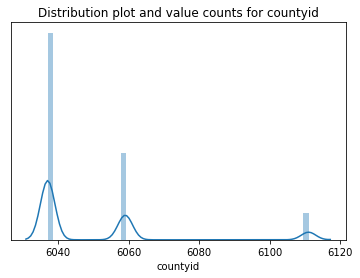

6037    26935
6059    11286
6111     3459
Name: countyid, dtype: int64


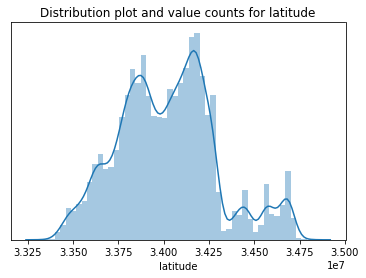

(33339141.852, 33488434.7]     604
(33488434.7, 33636249.4]      2592
(33636249.4, 33784064.1]      4821
(33784064.1, 33931878.8]      8734
(33931878.8, 34079693.5]      7230
(34079693.5, 34227508.2]      9859
(34227508.2, 34375322.9]      3678
(34375322.9, 34523137.6]      1455
(34523137.6, 34670952.3]      1694
(34670952.3, 34818767.0]      1013
Name: latitude, dtype: int64


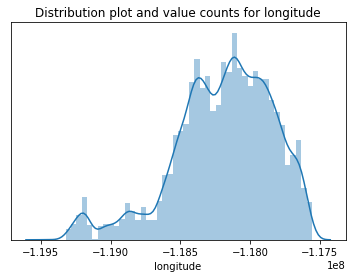

(-119477336.044, -119283411.7]     119
(-119283411.7, -119091407.4]      1025
(-119091407.4, -118899403.1]       825
(-118899403.1, -118707398.8]      1425
(-118707398.8, -118515394.5]      3037
(-118515394.5, -118323390.2]      7402
(-118323390.2, -118131385.9]      8012
(-118131385.9, -117939381.6]      8948
(-117939381.6, -117747377.3]      7280
(-117747377.3, -117555373.0]      3607
Name: longitude, dtype: int64


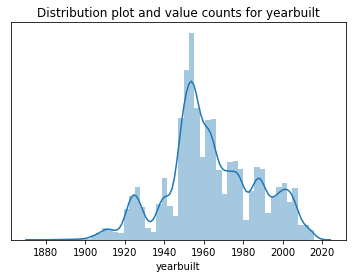

(1877.861, 1891.8]       20
(1891.8, 1905.6]        141
(1905.6, 1919.4]        826
(1919.4, 1933.2]       3242
(1933.2, 1947.0]       3905
(1947.0, 1960.8]      12687
(1960.8, 1974.6]       8201
(1974.6, 1988.4]       5508
(1988.4, 2002.2]       4719
(2002.2, 2016.0]       2431
Name: yearbuilt, dtype: int64


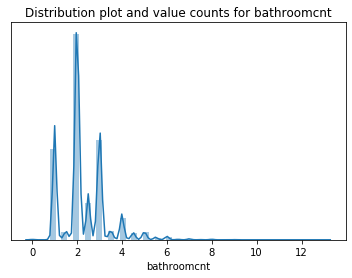

2.0     17401
3.0      8472
1.0      7639
2.5      3138
4.0      1808
3.5       733
1.5       675
5.0       635
4.5       534
6.0       252
5.5       188
7.0        70
8.0        39
6.5        37
0.0        28
7.5        13
9.0        10
10.0        3
8.5         2
11.0        2
13.0        1
Name: bathroomcnt, dtype: int64


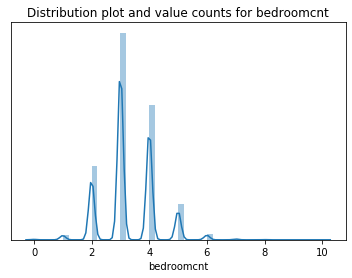

3     18606
4     12129
2      6655
5      3181
6       497
1       464
7        81
0        42
8        18
9         5
10        2
Name: bedroomcnt, dtype: int64


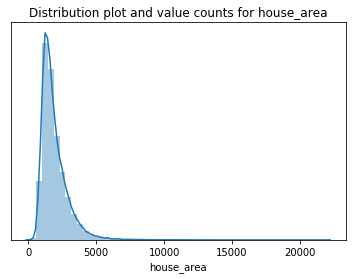

(106.198, 2308.1]     31269
(2308.1, 4488.2]       9457
(4488.2, 6668.3]        790
(6668.3, 8848.4]        119
(8848.4, 11028.5]        31
(11028.5, 13208.6]        9
(13208.6, 15388.7]        1
(15388.7, 17568.8]        2
(17568.8, 19748.9]        0
(19748.9, 21929.0]        2
Name: house_area, dtype: int64


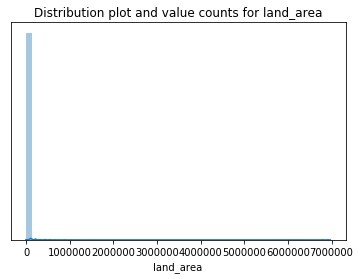

(-9303.114, 694880.3]     41665
(694880.3, 1392091.6]         7
(1392091.6, 2089302.9]        0
(2089302.9, 2786514.2]        1
(2786514.2, 3483725.5]        0
(3483725.5, 4180936.8]        0
(4180936.8, 4878148.1]        0
(4878148.1, 5575359.4]        0
(5575359.4, 6272570.7]        0
(6272570.7, 6969782.0]        7
Name: land_area, dtype: int64


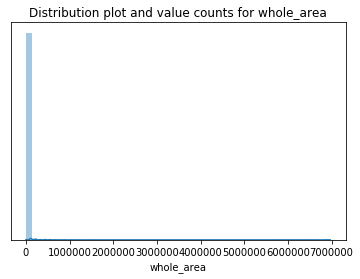

(-6734.775000000001, 697313.4]    41665
(697313.4, 1394390.8]                 7
(1394390.8, 2091468.2]                0
(2091468.2, 2788545.6]                1
(2788545.6, 3485623.0]                0
(3485623.0, 4182700.4]                0
(4182700.4, 4879777.8]                0
(4879777.8, 5576855.2]                0
(5576855.2, 6273932.6]                0
(6273932.6, 6971010.0]                7
Name: whole_area, dtype: int64


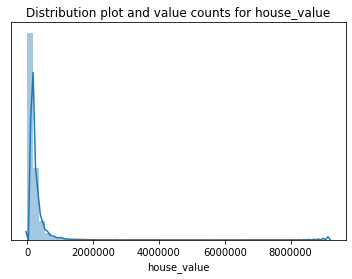

(-9035.773000000001, 916606.2]    40965
(916606.2, 1833083.4]               591
(1833083.4, 2749560.6]               79
(2749560.6, 3666037.8]               29
(3666037.8, 4582515.0]                6
(4582515.0, 5498992.2]                3
(5498992.2, 6415469.4]                1
(6415469.4, 7331946.6]                1
(7331946.6, 8248423.8]                4
(8248423.8, 9164901.0]                1
Name: house_value, dtype: int64


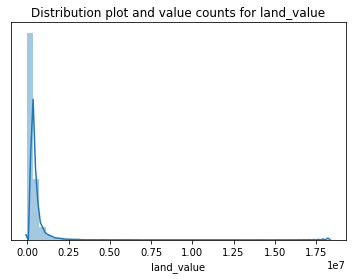

(-18113.34, 1827594.9]      41093
(1827594.9, 3655028.8]        459
(3655028.8, 5482462.7]         76
(5482462.7, 7309896.6]         31
(7309896.6, 9137330.5]          9
(9137330.5, 10964764.4]         5
(10964764.4, 12792198.3]        3
(12792198.3, 14619632.2]        1
(14619632.2, 16447066.1]        2
(16447066.1, 18274500.0]        1
Name: land_value, dtype: int64


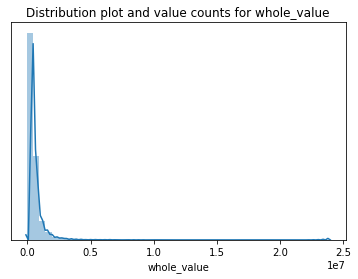

(-20601.121, 2388766.0]     40929
(2388766.0, 4774278.0]        595
(4774278.0, 7159790.0]        104
(7159790.0, 9545302.0]         27
(9545302.0, 11930814.0]        10
(11930814.0, 14316326.0]        7
(14316326.0, 16701838.0]        2
(16701838.0, 19087350.0]        2
(19087350.0, 21472862.0]        2
(21472862.0, 23858374.0]        2
Name: whole_value, dtype: int64


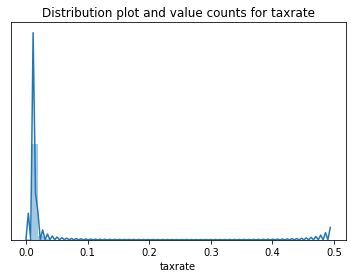

(-0.0014, 0.0494]    41611
(0.0494, 0.0988]        50
(0.0988, 0.148]         12
(0.148, 0.198]           2
(0.198, 0.247]           1
(0.247, 0.296]           1
(0.296, 0.346]           1
(0.346, 0.395]           0
(0.395, 0.444]           0
(0.444, 0.494]           2
Name: taxrate, dtype: int64


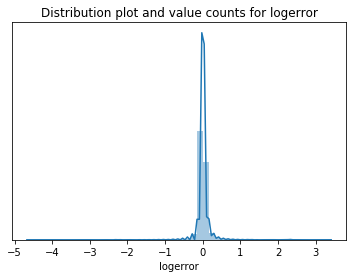

(-4.664000000000001, -3.85]        2
(-3.85, -3.045]                    0
(-3.045, -2.24]                   13
(-2.24, -1.435]                   15
(-1.435, -0.63]                   99
(-0.63, 0.175]                 39273
(0.175, 0.98]                   2120
(0.98, 1.785]                     85
(1.785, 2.59]                     65
(2.59, 3.395]                      8
Name: logerror, dtype: int64


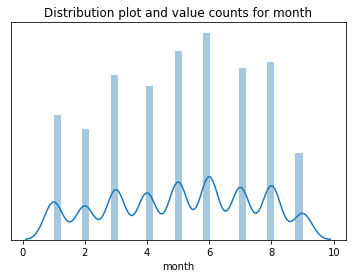

6    6229
5    5693
8    5342
7    5165
3    4948
4    4619
1    3741
2    3336
9    2607
Name: month, dtype: int64


In [25]:
explore.features_num_values(train)

## Scale?

## Explore part 2

**Look for clusters in month**

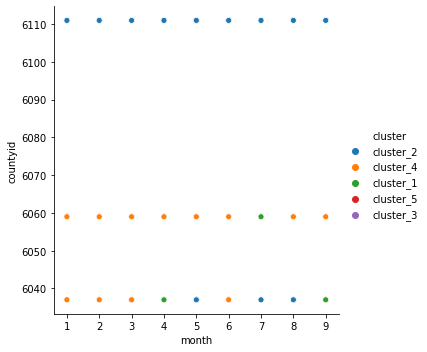

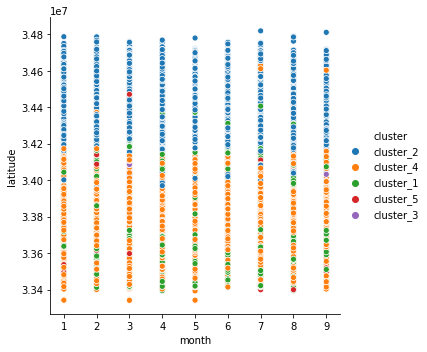

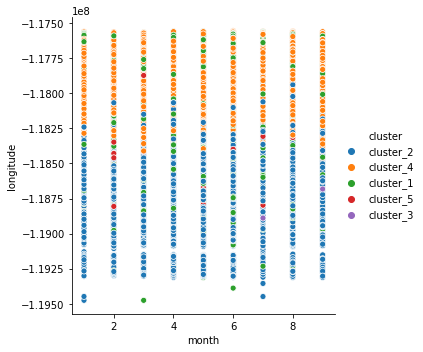

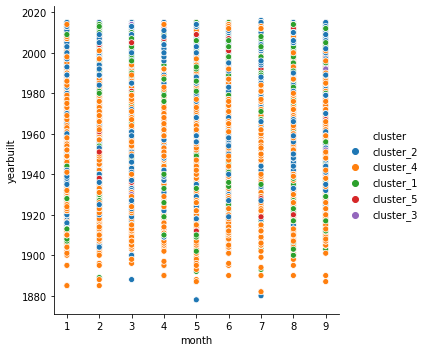

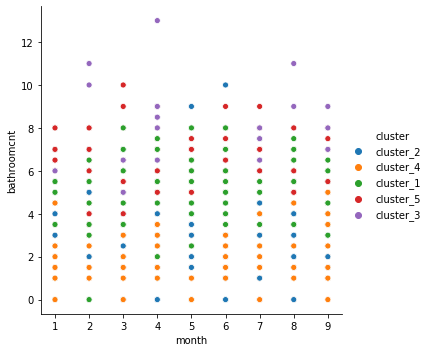

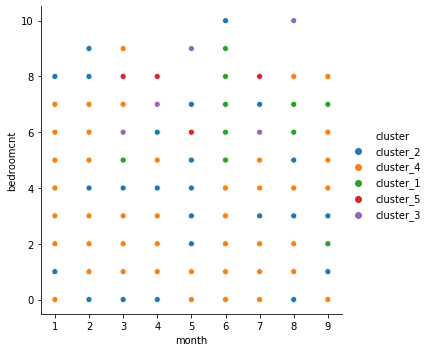

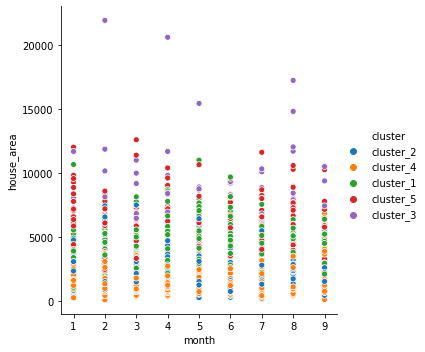

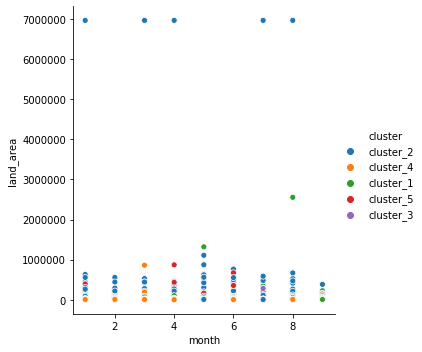

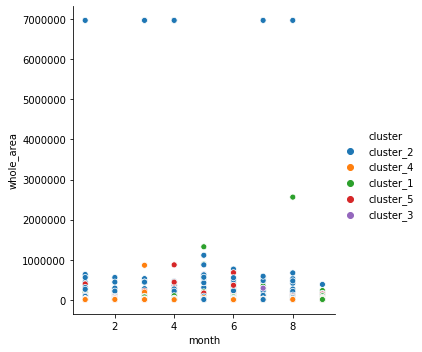

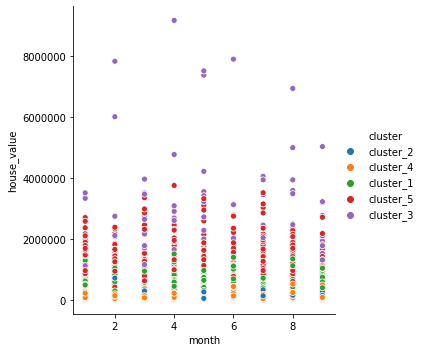

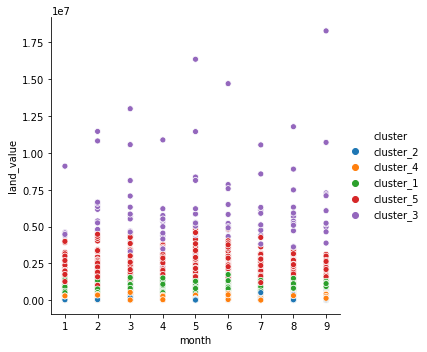

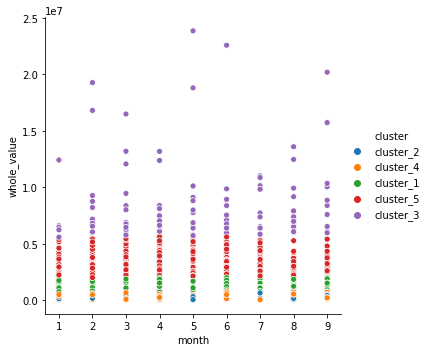

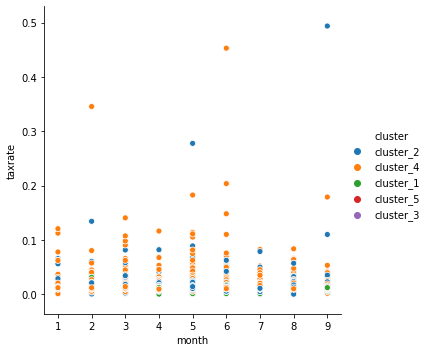

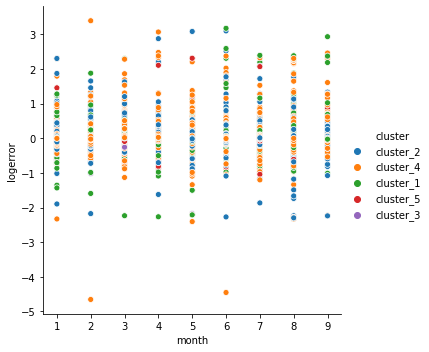

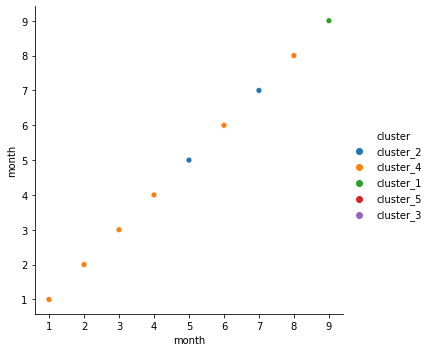

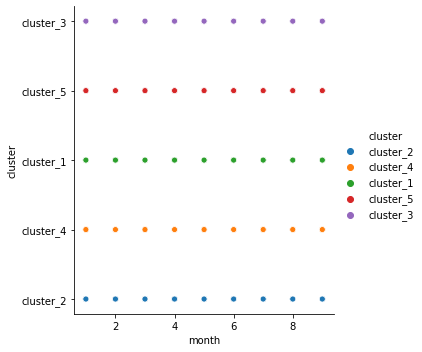

In [26]:
explore.k_cluster_all(train, "month", 5)

There were no significant clusters in the month feature.

**Look for clusters in yearbuilt.**

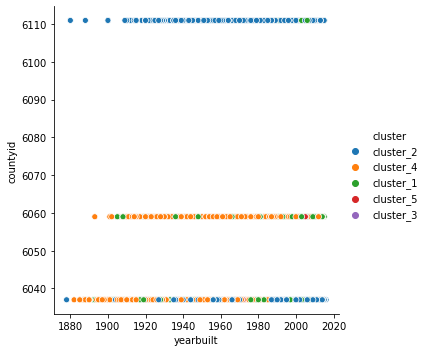

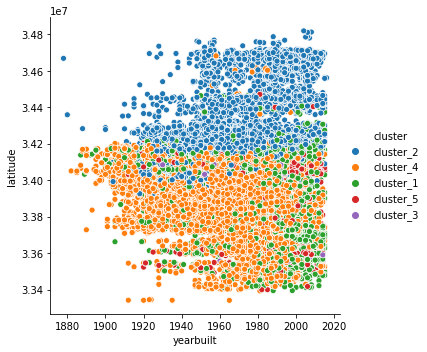

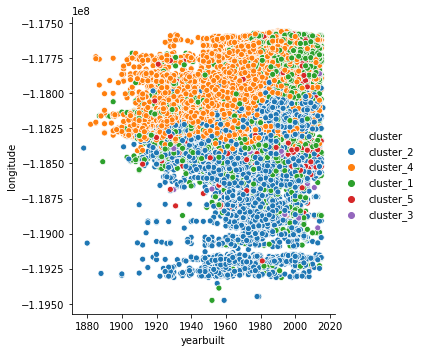

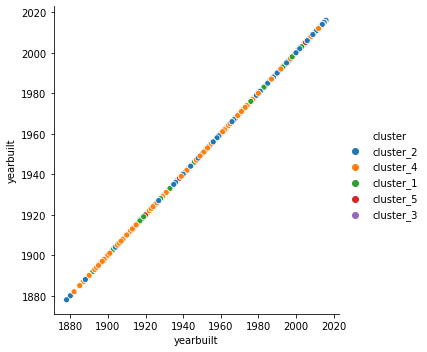

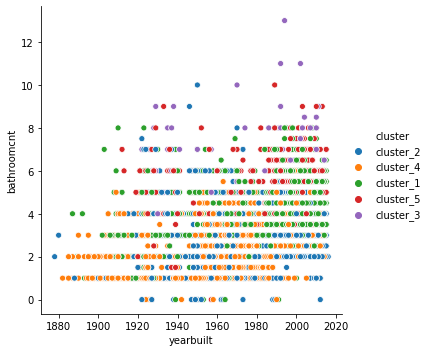

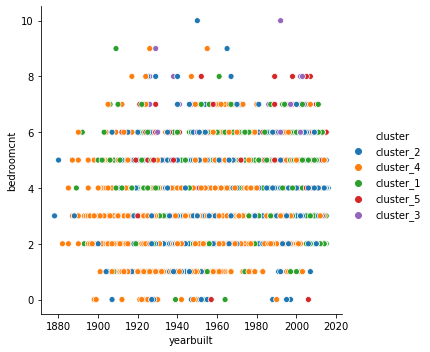

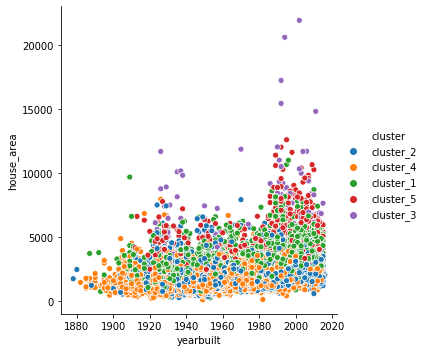

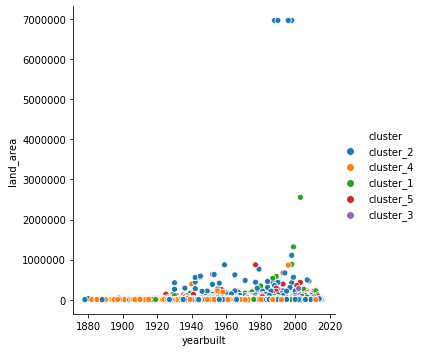

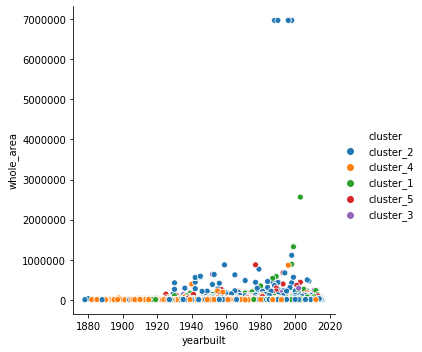

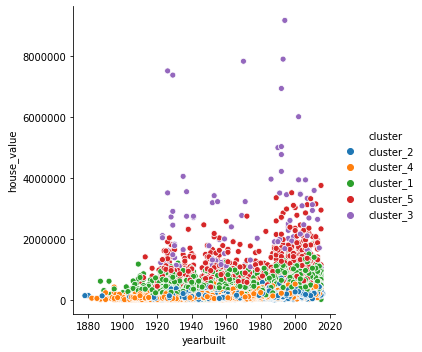

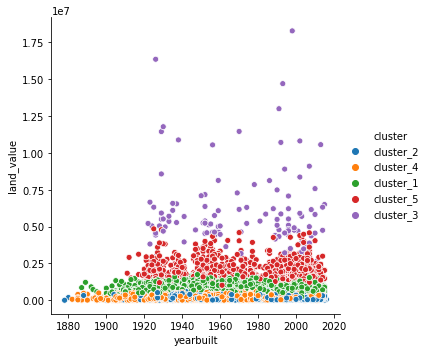

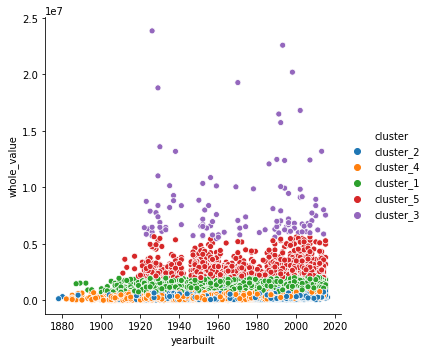

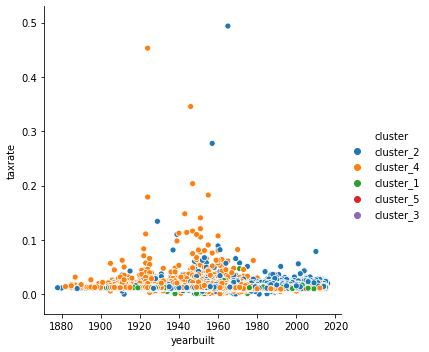

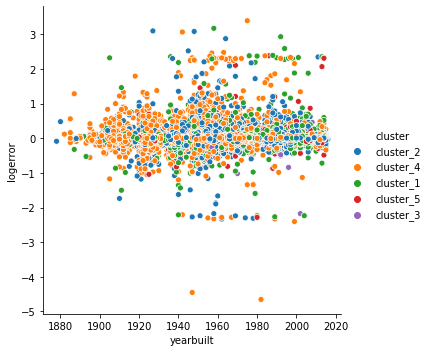

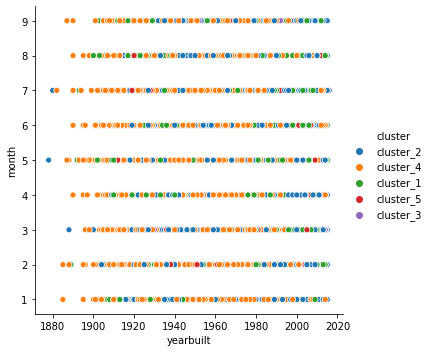

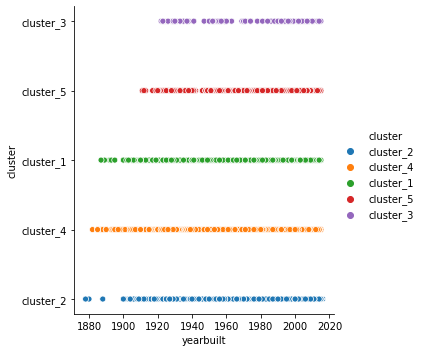

In [27]:
explore.k_cluster_all(train, "yearbuilt", 5)

There were no noteable clusters in the year built.

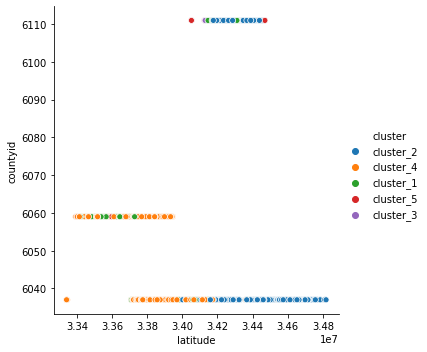

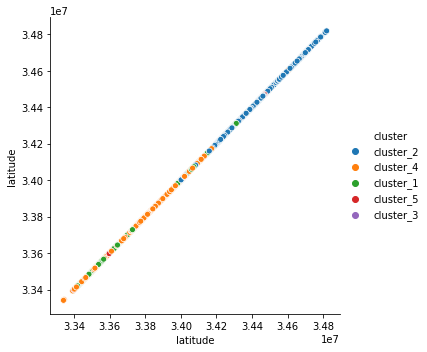

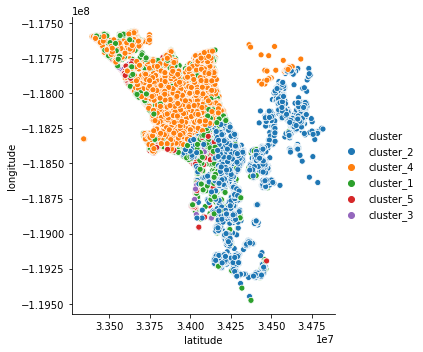

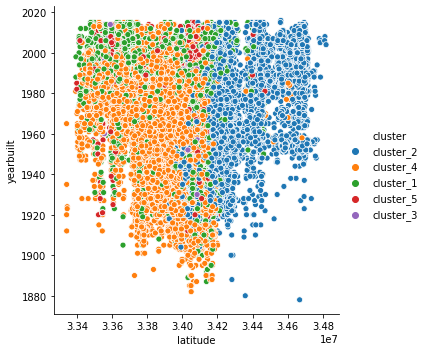

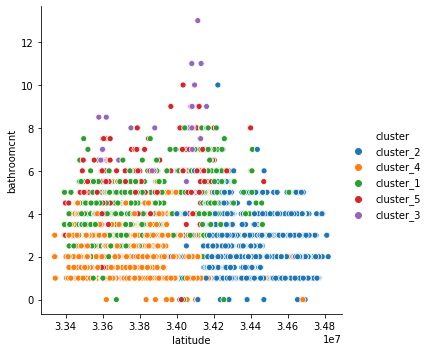

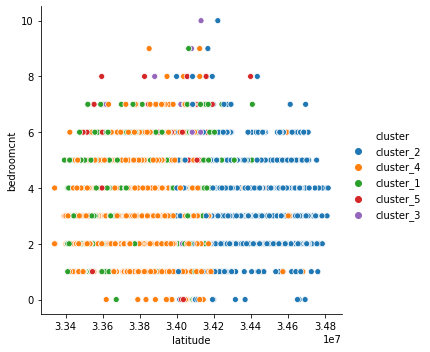

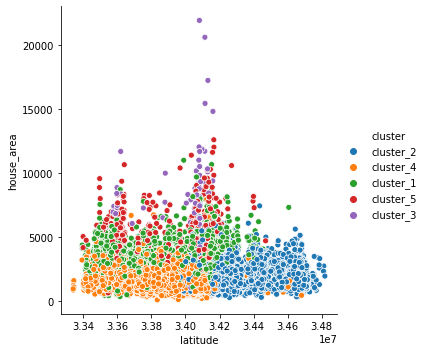

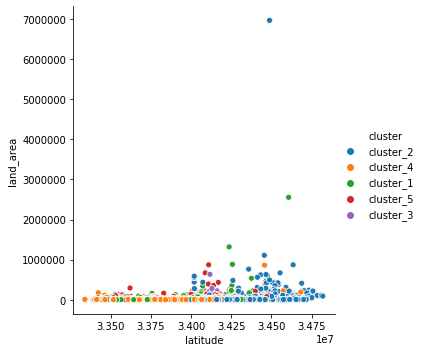

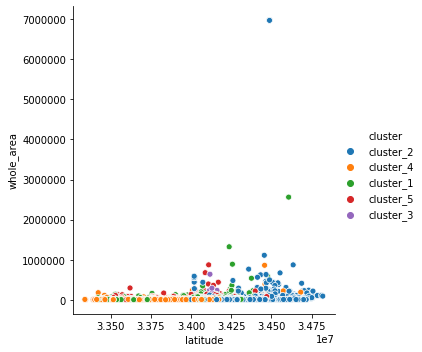

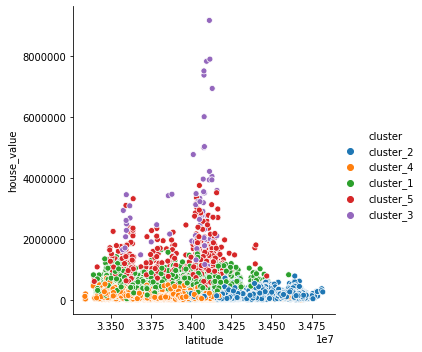

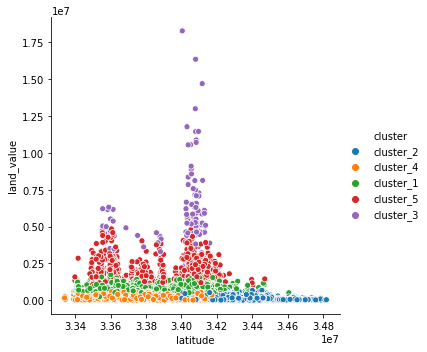

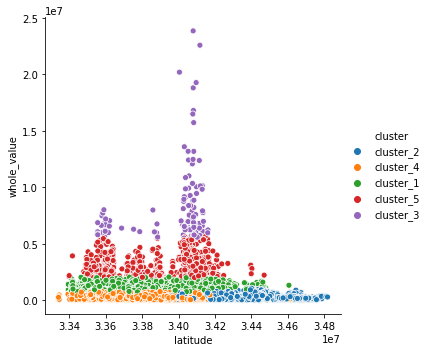

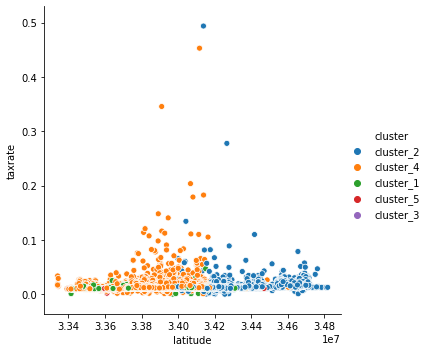

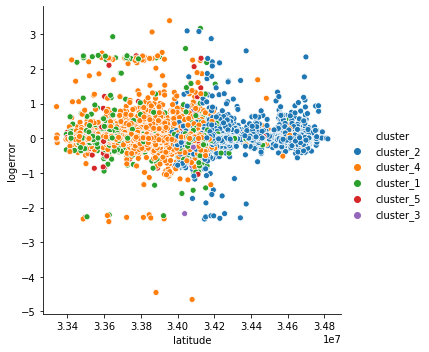

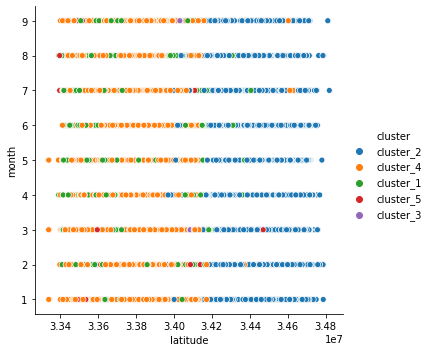

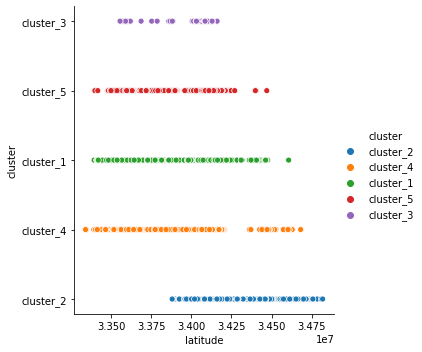

In [28]:
explore.k_cluster_all(train, "latitude", 5)

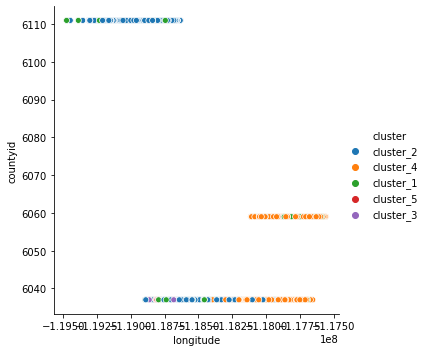

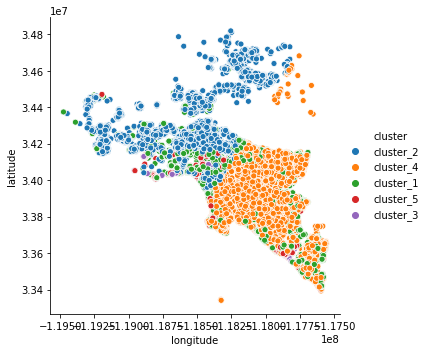

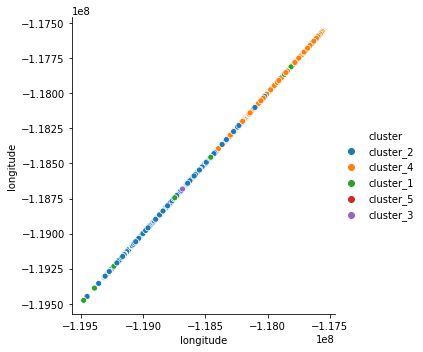

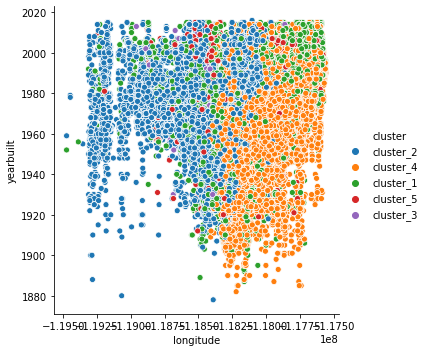

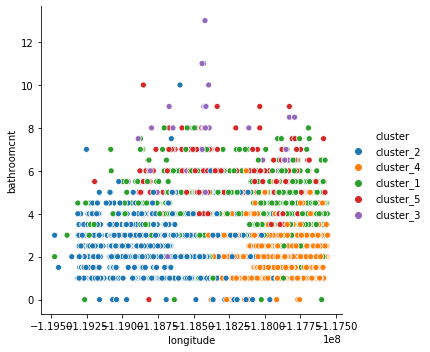

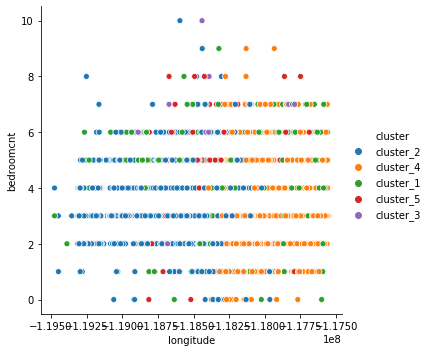

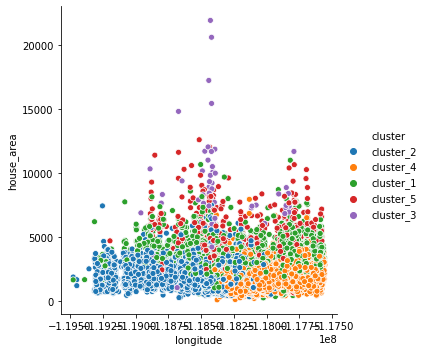

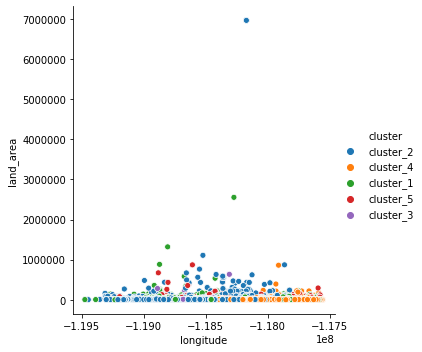

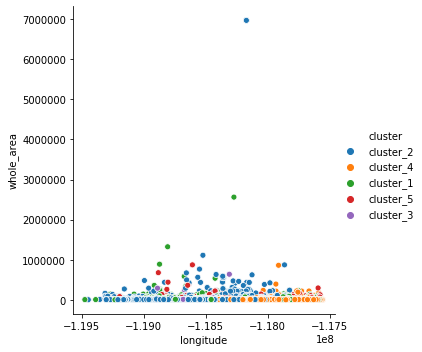

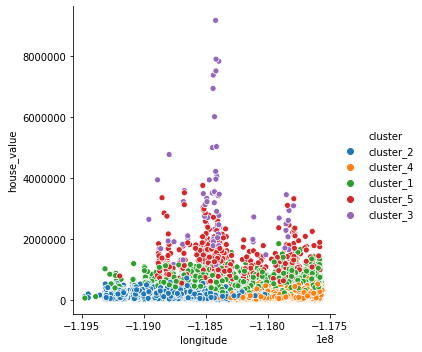

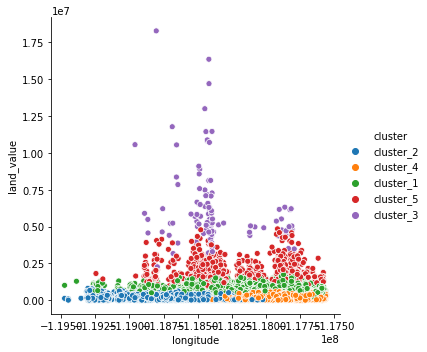

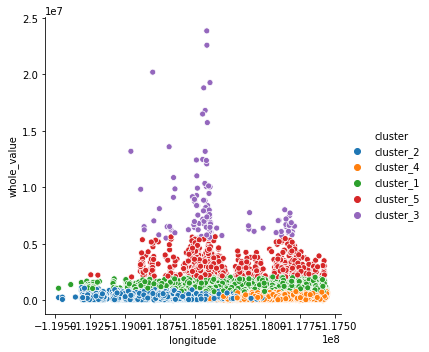

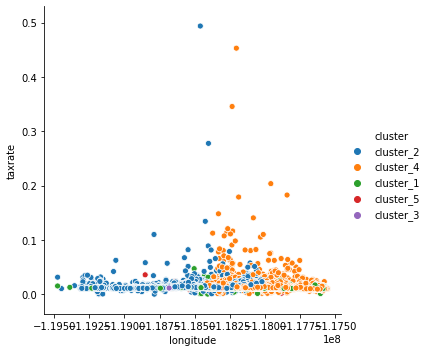

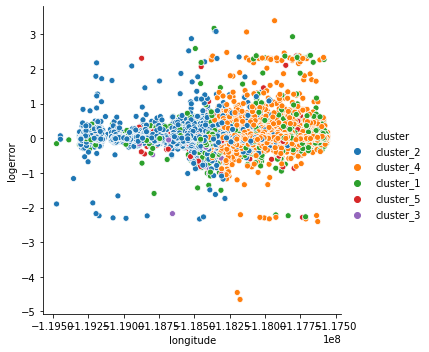

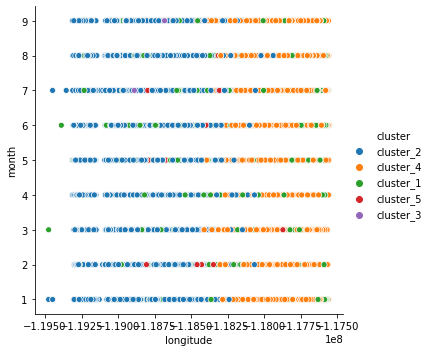

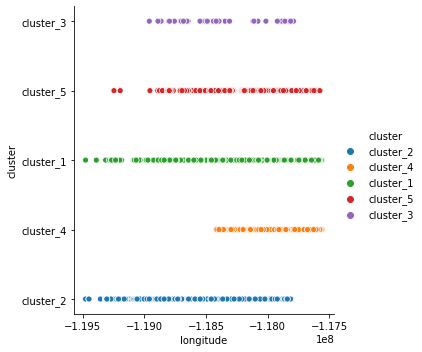

In [29]:
explore.k_cluster_all(train, "longitude", 5)

There are noticable clusters in latitude and longitude. As well as latitude and longitude with house area. Will explore both more. 

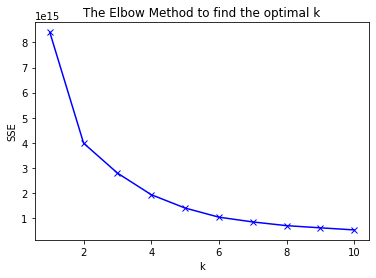

In [54]:
explore.elbow(train[["latitude","longitude"]])

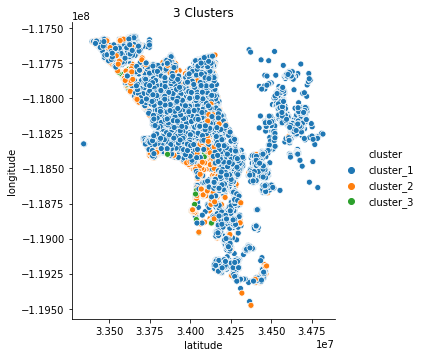

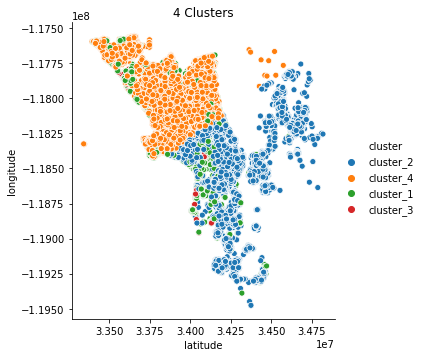

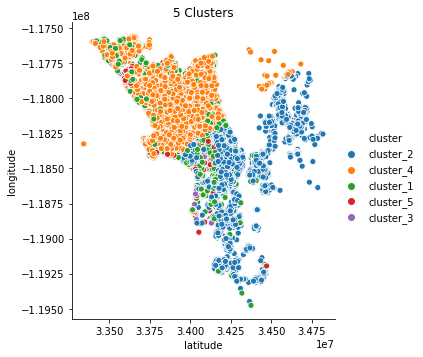

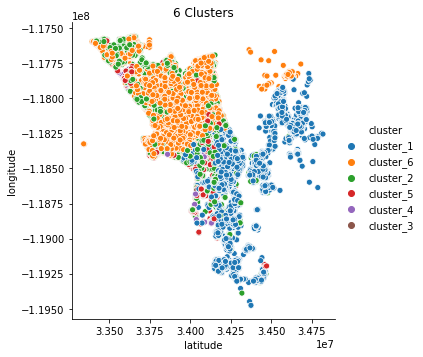

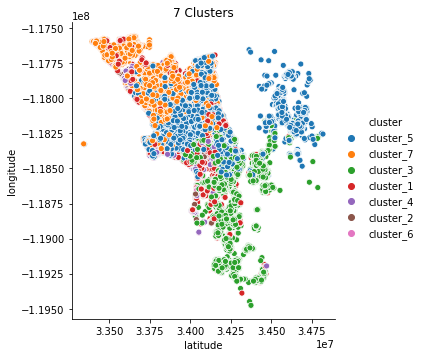

In [57]:
explore.k_cluster_2d(train, "latitude", "longitude", 7, 3)

Will use 4 clusters for latitude and longitude